## Contents

- [Introduction](meta_gradient_boosting.ipynb#introduction)
- [1. Data Loading](#1-data-loading)
- [2. Feature Engineering](#2-feature-engineering)
- [3. Label definition: "good trades"](#3-label-definition-good-trades)
- [4. Modeling dataset](#4-modeling-dataset)
- [5. Gradient Boosting with time-series CV](#5-gradient-boosting-with-time-series-cv)
- [5a. Overall out-of-sample ROC curve](#5a-overall-out-of-sample-roc-curve)
- [6. Feature importance](#6-feature-importance)
- [6a. Simple probability-based entry rule](#6a-simple-probability-based-entry-rule)
- [6b. In-sample ROC for the final model (optimistic)](#6b-in-sample-roc-for-the-final-model-optimistic)
- [7. Simple equity curve vs. buy & hold](#7-simple-equity-curve-vs-buy--hold)
- [8. Takeaways](#8-takeaways)
- [Why Gradient Boosting (and not just Logistic Regression)?](#why-gradient-boosting-and-not-just-logistic-regression)

# META Gradient Boosting Model

<a id="introduction"></a>
## Introduction

In this notebook I build a simple end-to-end ML pipeline on daily stock data.

The goal is to:

- Download daily OHLCV data for META from Yahoo Finance
- Engineer a set of technical features (RSI, EMA, ATR, Bollinger Bands, MACD, rolling stats, lags)
- Define a forward-looking label that captures "good trades" based on a take-profit (TP) and stop-loss (SL) within a fixed horizon
- Train a Gradient Boosting classifier with time-series cross-validation to predict a pre-defined binary target (“good trade within 20 days given TP/SL”)
- Inspect feature importances and overall model quality
- Show how model probabilities can be turned into a simple, decision-oriented rule

This is **not** intended as a production-ready trading system.
The goal is to demonstrate how I approach:

- Feature engineering on time series
- Respecting temporal order (no leakage)
- Translating model outputs into something that can support decisions (here: a simple “enter / don’t enter” rule).

### Why Gradient Boosting (and not just Logistic Regression)?

For this case I use a **Gradient Boosting classifier** as the main model because:

- **Non-linear relationships**
  The label (“good trade within 20 days given TP/SL”) is a non-linear function of volatility, momentum, and volume (and factors not covered here). Tree ensembles naturally capture such non-linearities, while logistic regression assumes a linear relationship in the log-odds.

- **Automatic interactions**
  Gradient Boosting trees can learn interactions like
  *“high long-term volatility **and** strong recent momentum”*
  without manually creating interaction terms. Logistic regression would need explicit engineered interaction features.

- **Robust to scaling**
  Tree-based models don’t require feature standardisation and can handle differently scaled inputs (prices, indicators, volumes) out of the box.

- **Interpretability via feature importance**
  Even though it’s more flexible than logistic regression, Gradient Boosting still gives simple **feature importance** scores, which makes it easy to see which indicators the model relies on most.

In practice, I would still compare this against a **regularised logistic regression baseline**, but Gradient Boosting is a reasonable first non-linear choice for noisy, technical-indicator-style features like these.

# Imports and Config

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import pandas_ta as ta

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve

# ---- config for DAILY data ----
HORIZON_BARS   = 20      # N trading days
TP             = 0.10    # +X% take profit within horizon
SL             = -0.05   # -Y% max drawdown within horizon

<a id="1-data-loading"></a>
## 1. Data Loading

I start by pulling **daily** OHLCV data for META from Yahoo Finance using `yfinance`.

Yahoo limits how far back intraday data goes, but for daily data I can retrieve the full available history. For this case study, I pull a few years of META price history (since 2020), which is enough to:

- Calculate technical indicators
- Train and validate a simple ML model in a time-aware way

I also:

- Rename the columns to lower case (`open`, `high`, `low`, `close`, `volume`)
- Make sure the index is a proper `DatetimeIndex`, sorted in ascending order

In [52]:
# Download META daily data
df = yf.download(
    "META",
    interval="1d",
    start="2020-01-01",
    auto_adjust=True,
    progress=False,
)

# Standardize column names
df = df.rename(
    columns={
        "Open": "open",
        "High": "high",
        "Low": "low",
        "Close": "close",
        "Volume": "volume",
    }
)

df = df.dropna().sort_index()
df.head()

Price,close,high,low,open,volume
Ticker,META,META,META,META,META
Date,,,,,
2020-01-02,208.494675,208.504608,205.006186,205.483241,12077100
2020-01-03,207.391479,209.110876,205.682017,205.940433,11188400
2020-01-06,211.297409,211.476299,205.254659,205.433549,17058900
2020-01-07,211.754593,213.265284,210.452622,211.516073,14912400
2020-01-08,213.901367,214.915122,211.307358,211.694968,13475000


In [53]:
df.index.min(), df.index.max(), len(df)

(Timestamp('2020-01-02 00:00:00'), Timestamp('2025-11-28 00:00:00'), 1486)

### Quick sanity check: META 1d price series

Before doing any feature engineering, I like to visually check the price series to make sure the data looks sensible and continuous.

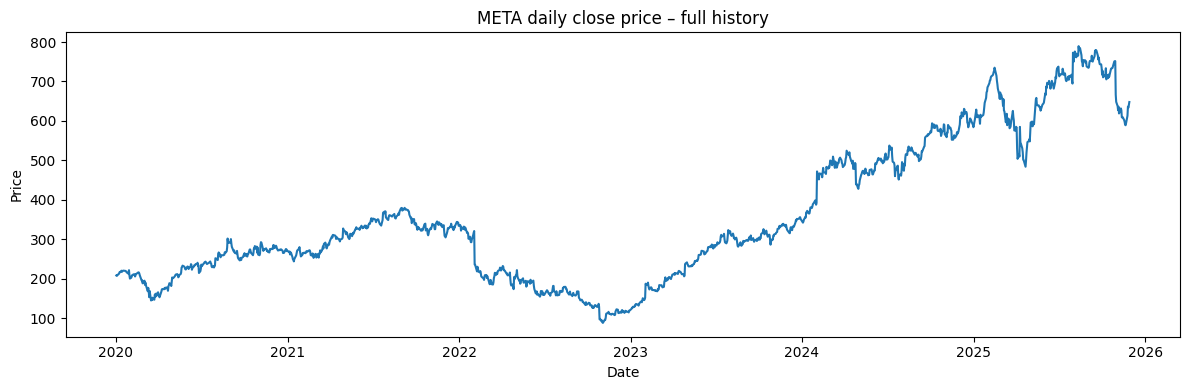

In [54]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df["close"])
plt.title("META daily close price – full history")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

<a id="2-feature-engineering"></a>
## 2. Feature Engineering

Here I build a modular "feature factory" that adds:

- **Technical indicators** via `pandas_ta`:
  - RSI (6, 12, 24)
  - EMA (20, 50, 100)
  - ATR (14)
  - Bollinger Bands (20)
  - MACD (12, 26, 9)
  - I also add simple calendar features (year and month) to capture broad regimes or seasonality.
- **Rolling statistics** (mean/std/max/min) on `close` and `volume` for multiple windows
- Simple **lag features** for `close` and `volume`

This gives the model a mix of momentum, trend, volatility, and basic micro-structure information.

In [55]:
def _add_ta_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add a small, opinionated bundle of TA features using pandas_ta.
    """
    # --- Momentum (RSI) ---
    df.ta.rsi(length=6, append=True)
    df.ta.rsi(length=12, append=True)
    df.ta.rsi(length=24, append=True)

    # --- Trend (EMAs) ---
    df.ta.ema(length=20, append=True)
    df.ta.ema(length=50, append=True)
    df.ta.ema(length=100, append=True)

    # --- Volatility (ATR, Bollinger Bands) ---
    df.ta.atr(length=14, append=True)
    df.ta.bbands(length=20, append=True)

    # --- MACD ---
    df.ta.macd(fast=12, slow=26, signal=9, append=True)

    return df


def _add_rolling_features(df: pd.DataFrame) -> pd.DataFrame:
    # nr of working days
    windows = [5, 20, 60, 200]  # 1w, 1m, 3m, ~1y
    cols = ["close", "volume"]

    for col in cols:
        for w in windows:
            roll = df[col].rolling(w)
            df[f"{col}_ma_{w}"] = roll.mean()
            df[f"{col}_std_{w}"] = roll.std()
            df[f"{col}_max_{w}"] = roll.max()
            df[f"{col}_min_{w}"] = roll.min()

    return df


def _add_lag_features(df: pd.DataFrame) -> pd.DataFrame:
    # lags in days
    lags = [1, 2, 5, 10, 20]
    cols = ["close", "volume"]

    for col in cols:
        for lag in lags:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)

    return df


def build_features(
    df: pd.DataFrame,
    add_ta: bool = True,
    add_rolling: bool = True,
    add_lags: bool = True,
    drop_na: bool = True,
) -> pd.DataFrame:
    """
    Minimal feature factory for OHLCV data.

    Assumes:
        - df.index is DatetimeIndex
        - df has ['open','high','low','close','volume']
    """
    df = df.copy().sort_index()

    if add_ta:
        df = _add_ta_features(df)

    if add_rolling:
        df = _add_rolling_features(df)

    if add_lags:
        df = _add_lag_features(df)

    if drop_na:
        df = df.dropna()

    return df

In [56]:
ohlcv_cols = ["open", "high", "low", "close", "volume"]

df_feat = build_features(
    df[ohlcv_cols],
    add_ta=True,
    add_rolling=True,
    add_lags=True,
    drop_na=True,
)

# Add calendar features
df_feat["year"] = df_feat.index.year
df_feat["month"] = df_feat.index.month

df_feat.head(), df_feat.shape

(Price             open        high         low       close    volume  \
 Ticker            META        META        META        META      META   
 Date                                                                   
 2020-10-15  265.960429  267.391608  262.054515  265.085815  15416100   
 2020-10-16  265.741757  269.707300  263.674484  264.300629  16622700   
 2020-10-19  263.903101  266.904587  258.287725  259.798401  13587000   
 2020-10-20  261.448196  268.047526  261.269306  265.920624  18763200   
 2020-10-21  277.847179  281.315787  274.676721  277.022278  28998600   
 
 Price       close_ma_5 close_std_5 close_max_5 close_min_5 close_ma_20  ...  \
 Ticker                                                                  ...   
 Date                                                                    ...   
 2020-10-15  269.315753    5.232544  274.448151  262.829742  259.199617  ...   
 2020-10-16  269.609930    4.800222  274.448151  264.300629  259.865510  ...   
 2020-10-19  2

In [57]:
# Inspecting available data
df_feat.iloc[:5, 40:50]

Price,close_lag_10,close_lag_20,volume_lag_1,volume_lag_2,volume_lag_5,volume_lag_10,volume_lag_20,year,month
Ticker,,,,,,,,,
Date,,,,,,,,,
2020-10-15,264.996429,253.258759,15577800.0,18063300.0,16312800.0,20009800.0,31281400.0,2020,10
2020-10-16,258.347382,250.982773,15416100.0,15577800.0,14107800.0,16367600.0,28130800.0,2020,10
2020-10-19,263.028503,246.629578,16622700.0,15416100.0,31019300.0,12822300.0,24709400.0,2020,10
2020-10-20,257.075195,253.189148,13587000.0,16622700.0,18063300.0,18696900.0,30293100.0,2020,10
2020-10-21,256.538544,247.494278,18763200.0,13587000.0,15577800.0,23133400.0,19641300.0,2020,10


<a id="3-label-definition-good-trades"></a>
## 3. Label definition: "good trades"

Next, I create a forward-looking label.

For each day *t* I look **20 trading days ahead** (roughly one month) and check:

- the **maximum** price reached within the next 20 days
- the **minimum** price reached within the next 20 days

From this I compute forward returns relative to today’s close:

- `max_fwd_ret` – best case within the horizon
- `min_fwd_ret` – worst case within the horizon

I then mark a day as a **"good trade"** (`good_trade = 1`) if:

- price goes up at least +X% at some point (`max_fwd_ret ≥ TP`), and
- the worst drawdown over the horizon stays better than −Y% (`min_fwd_ret > SL`).

This is a simplified, horizon-based definition; it doesn’t model the exact TP/SL hit order, but it’s a reasonable proxy for “there was a clean long opportunity here”.

In [58]:
## 3. Label definition: "good trades"

# For each day t, look N trading days ahead and compute:
# - the minimum low in that forward window
# - the maximum high in that forward window
# Then define a "good trade" if:
#   max_fwd_ret ≥ TP and min_fwd_ret > SL.

idx = df_feat.index

# Build a clean label frame aligned to feature dates
lab = pd.DataFrame(index=idx)
lab["close"] = df.loc[idx, "close"].to_numpy()
lab["high"] = df.loc[idx, "high"].to_numpy()
lab["low"] = df.loc[idx, "low"].to_numpy()

n = len(lab)
lows = lab["low"].to_numpy()
highs = lab["high"].to_numpy()

future_min_low = np.full(n, np.nan)
future_max_high = np.full(n, np.nan)

# For each i, look at the NEXT HORIZON_BARS days: (i+1 ... i+HORIZON_BARS)
for i in range(n):
    end = i + 1 + HORIZON_BARS
    if end <= n:
        window = slice(i + 1, end)
        future_min_low[i] = lows[window].min()
        future_max_high[i] = highs[window].max()
    # else: leave as NaN (not enough future data)

lab["future_min_low"] = future_min_low
lab["future_max_high"] = future_max_high

# Forward returns relative to today's close
lab["max_fwd_ret"] = lab["future_max_high"] / lab["close"] - 1.0
lab["min_fwd_ret"] = lab["future_min_low"] / lab["close"] - 1.0

# Drop rows without full forward window
lab = lab.dropna(subset=["max_fwd_ret", "min_fwd_ret"])

# Binary label
lab["good_trade"] = (
        (lab["max_fwd_ret"] >= TP) &
        (lab["min_fwd_ret"] > SL)
).astype(int)

lab[["close", "max_fwd_ret", "min_fwd_ret", "good_trade"]].head(), lab["good_trade"].mean()

(                 close  max_fwd_ret  min_fwd_ret  good_trade
 Date                                                        
 2020-10-15  265.085815     0.114952    -0.035168           1
 2020-10-16  264.300629     0.118264    -0.032302           1
 2020-10-19  259.798401     0.137644    -0.015532           1
 2020-10-20  265.920624     0.111452    -0.038197           1
 2020-10-21  277.022278     0.066911    -0.076741           0,
 np.float64(0.2991318074191002))

In [59]:
lab["good_trade"].value_counts()

good_trade
0    888
1    379
Name: count, dtype: int64

In [60]:
# Ensure df_feat has a single level of columns (pandas_ta sometimes returns MultiIndex)
if isinstance(df_feat.columns, pd.MultiIndex):
    df_feat = df_feat.copy()
    df_feat.columns = [
        "_".join([str(level) for level in col if level not in (None, "")])
        for col in df_feat.columns.to_list()
    ]

df_feat.columns.nlevels, df_feat.columns[:10]

(1,
 Index(['open_META', 'high_META', 'low_META', 'close_META', 'volume_META',
        'close_ma_5', 'close_std_5', 'close_max_5', 'close_min_5',
        'close_ma_20'],
       dtype='object'))

In [61]:
df_model = df_feat.join(
    lab[["future_min_low", "future_max_high", "max_fwd_ret", "min_fwd_ret", "good_trade"]],
    how="inner",
)

df_model = df_model.dropna(subset=["good_trade"])

In [62]:
df_model.head()

,open_META,high_META,low_META,close_META,volume_META,close_ma_5,close_std_5,close_max_5,close_min_5,close_ma_20,...,volume_lag_5,volume_lag_10,volume_lag_20,year,month,future_min_low,future_max_high,max_fwd_ret,min_fwd_ret,good_trade
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-15,265.960429,267.391608,262.054515,265.085815,15416100,269.315753,5.232544,274.448151,262.829742,259.199617,...,16312800.0,20009800.0,31281400.0,2020,10,255.763308,295.557981,0.114952,-0.035168,1
2020-10-16,265.741757,269.707300,263.674484,264.300629,16622700,269.609930,4.800222,274.448151,264.300629,259.865510,...,14107800.0,16367600.0,28130800.0,2020,10,255.763308,295.557981,0.118264,-0.032302,1
2020-10-19,263.903101,266.904587,258.287725,259.798401,13587000,266.757520,5.655666,274.448151,259.798401,260.523951,...,31019300.0,12822300.0,24709400.0,2020,10,255.763308,295.557981,0.137644,-0.015532,1
2020-10-20,261.448196,268.047526,261.269306,265.920624,18763200,265.052014,3.706651,270.154602,259.798401,261.160525,...,18063300.0,18696900.0,30293100.0,2020,10,255.763308,295.557981,0.111452,-0.038197,1
2020-10-21,277.847179,281.315787,274.676721,277.022278,28998600,266.425549,6.379163,277.022278,259.798401,262.636925,...,15577800.0,23133400.0,19641300.0,2020,10,255.763308,295.557981,0.066911,-0.076741,0


In [63]:
# Inspecting available data
df_model.iloc[:5, 40:52]

,close_lag_10,close_lag_20,volume_lag_1,volume_lag_2,volume_lag_5,volume_lag_10,volume_lag_20,year,month,future_min_low,future_max_high,max_fwd_ret
Date,,,,,,,,,,,,
2020-10-15,264.996429,253.258759,15577800.0,18063300.0,16312800.0,20009800.0,31281400.0,2020,10,255.763308,295.557981,0.114952
2020-10-16,258.347382,250.982773,15416100.0,15577800.0,14107800.0,16367600.0,28130800.0,2020,10,255.763308,295.557981,0.118264
2020-10-19,263.028503,246.629578,16622700.0,15416100.0,31019300.0,12822300.0,24709400.0,2020,10,255.763308,295.557981,0.137644
2020-10-20,257.075195,253.189148,13587000.0,16622700.0,18063300.0,18696900.0,30293100.0,2020,10,255.763308,295.557981,0.111452
2020-10-21,256.538544,247.494278,18763200.0,13587000.0,15577800.0,23133400.0,19641300.0,2020,10,255.763308,295.557981,0.066911


<a id="4-modeling-dataset"></a>
## 4. Modeling dataset

At this point I have:

- `df_feat`: engineered technical features
- `lab`: forward-looking returns and `good_trade` label
- `df_model`: their inner join on the date index

Next I:
- Select all numeric feature columns
- Keep `good_trade` as the target
- Prepare `X` / `y` for modeling

In [64]:
target_col = "good_trade"

# Dropping target and redundant columns from feats
non_feature_cols = {
    target_col,
    "future_min_low",
    "future_max_high",
    "max_fwd_ret",
    "min_fwd_ret",
}

# Use all numeric columns except explicitly excluded ones
feature_cols = [
    c for c in df_model.columns
    if c not in non_feature_cols and pd.api.types.is_numeric_dtype(df_model[c])
]

len(df_model), len(feature_cols), feature_cols[:10]

(1267,
 49,
 ['open_META',
  'high_META',
  'low_META',
  'close_META',
  'volume_META',
  'close_ma_5',
  'close_std_5',
  'close_max_5',
  'close_min_5',
  'close_ma_20'])

In [65]:
# Chronological order is critical for time-series CV
df_model = df_model.sort_index()

X = df_model[feature_cols].values
y = df_model[target_col].astype(int).values

print("Rows:", X.shape[0])
print("Features:", X.shape[1])
print("Share of good trades:", y.mean().round(3))

Rows: 1267
Features: 49
Share of good trades: 0.299


<a id="5-gradient-boosting-with-time-series-cv"></a>
## 5. Gradient Boosting with time-series CV

I use a `GradientBoostingClassifier` and `TimeSeriesSplit` to respect the temporal structure.

For each fold:

- Train on the **past**
- Evaluate on a **future** segment
- Store predicted probabilities for `good_trade = 1`

This gives an honest, walk-forward estimate of model performance and probabilities.

In [66]:
tscv = TimeSeriesSplit(n_splits=5)

proba_all = np.full(len(df_model), np.nan)
pred_all  = np.full(len(df_model), np.nan)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.02,
        max_depth=3,
        subsample=0.8,
        random_state=42,
    )
    clf.fit(X_train, y_train)

    # --- train metrics ---
    y_train_proba = clf.predict_proba(X_train)[:, 1]
    y_train_pred  = clf.predict(X_train)
    train_auc     = roc_auc_score(y_train, y_train_proba)

    # --- test metrics (out-of-sample for this fold) ---
    y_test_proba = clf.predict_proba(X_test)[:, 1]
    y_test_pred  = clf.predict(X_test)
    try:
        test_auc = roc_auc_score(y_test, y_test_proba)
    except ValueError:
        test_auc = np.nan

    pred_all[test_idx]  = y_test_pred
    proba_all[test_idx] = y_test_proba

    print(f"\n=== Fold {fold} ===")
    print(f"Train ROC AUC: {train_auc:.4f}")
    print(f"Test  ROC AUC: {test_auc:.4f}")
    print(classification_report(y_test, y_test_pred, digits=3))


=== Fold 1 ===
Train ROC AUC: 1.0000
Test  ROC AUC: 0.5344
              precision    recall  f1-score   support

           0      0.941     0.575     0.714       193
           1      0.118     0.611     0.198        18

    accuracy                          0.578       211
   macro avg      0.529     0.593     0.456       211
weighted avg      0.871     0.578     0.670       211


=== Fold 2 ===
Train ROC AUC: 1.0000
Test  ROC AUC: 0.7002
              precision    recall  f1-score   support

           0      0.760     0.339     0.469       112
           1      0.540     0.879     0.669        99

    accuracy                          0.592       211
   macro avg      0.650     0.609     0.569       211
weighted avg      0.657     0.592     0.563       211


=== Fold 3 ===
Train ROC AUC: 0.9970
Test  ROC AUC: 0.5995
              precision    recall  f1-score   support

           0      0.505     0.991     0.669       106
           1      0.667     0.019     0.037       105

  

The five time-series folds show that train AUC is very high (the model can fit the past) but test AUC is only around 0.6 on average.
This means the model has some predictive signal out-of-sample, but it is weak and far from a reliable trading edge.

In [67]:
df_model["proba"] = proba_all
df_model["pred"] = pred_all

df_model = df_model.dropna(subset=["proba"])
df_model[["good_trade", "proba"]].tail()

,good_trade,proba
Date,,
2025-10-24,0,0.129074
2025-10-27,0,0.145275
2025-10-28,0,0.139357
2025-10-29,0,0.142916
2025-10-30,0,0.226710


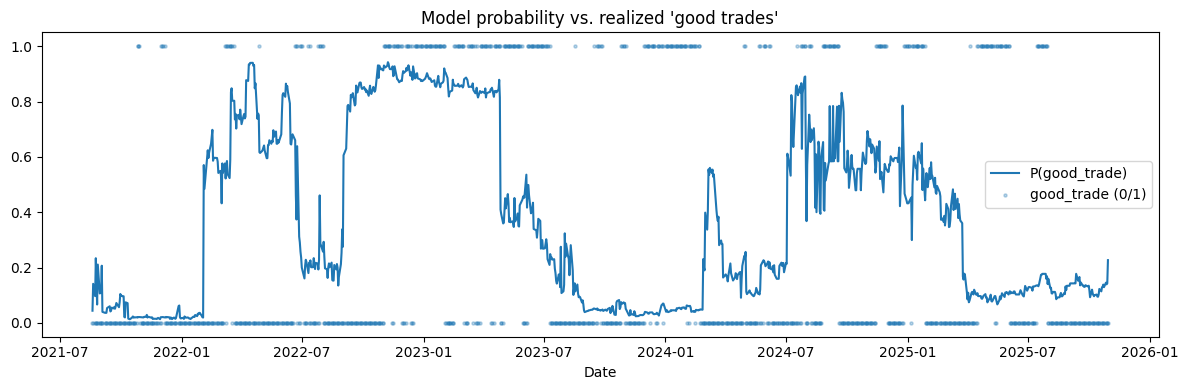

In [68]:
plt.figure(figsize=(12, 4))
plt.plot(df_model.index, df_model["proba"], label="P(good_trade)")
plt.scatter(
    df_model.index, df_model["good_trade"],
    s=5, alpha=0.3, label="good_trade (0/1)"
)
plt.title("Model probability vs. realized 'good trades'")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

The blue line shows the model’s estimated probability of a “good trade” each day, while the dots on the top/bottom show whether it actually turned out good (1) or not (0).
You can see that many of the 1-days cluster when the probability is higher, but there is still a lot of noise and misses.

<a id="5a-overall-out-of-sample-roc-curve"></a>
## 5a. Overall out-of-sample ROC curve

Using the cross-validated probabilities, I can compute a single,
global ROC curve and AUC that summarise performance across all folds.

This treats each test fold as a small out-of-sample slice and then
stitches them together into one evaluation.

In [69]:
# Mask out the rows that were never in a test fold (should be few at the very start)
mask = ~np.isnan(proba_all)
y_oos = y[mask]
proba_oos = proba_all[mask]

overall_auc = roc_auc_score(y_oos, proba_oos)
fpr, tpr, thresholds = roc_curve(y_oos, proba_oos)

print(f"Overall out-of-sample ROC AUC: {overall_auc:.4f}")

Overall out-of-sample ROC AUC: 0.5856


The cross-validated performance is modest: the overall out-of-sample ROC AUC is around 0.58, only slightly better than random, and the model is still conservative on 'good trades' (class 1), with many misses.

This is not surprising given:
- A single stock (META) with a noisy label (TP/SL hit somewhere in the next 20 days)
- No macro or cross-sectional information
- A small tree-based model with only light manual tuning (no large-scale search)

For the purposes of this notebook, I’m more interested in demonstrating a clean, time-aware ML workflow
than in squeezing maximum alpha out of this setup.

<a id="6-feature-importance"></a>
## 6. Feature importance

To understand what the model is using, I fit a Gradient Boosting classifier
on the full dataset and inspect the feature importances.

In [70]:
final_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.02,
    max_depth=3,
    subsample=0.8,
    random_state=42,
)
final_clf.fit(X, y)

feat_imp = (
    pd.Series(final_clf.feature_importances_, index=feature_cols)
    .sort_values(ascending=False)
    .to_frame("importance")
)

feat_imp.head(20)

,importance
close_ma_200,0.194728
volume_min_60,0.124243
close_std_60,0.093290
close_std_200,0.072297
close_std_5,0.055537
close_std_20,0.043895
volume_ma_200,0.038072
volume_std_60,0.037117
close_ma_60,0.031968
close_max_200,0.029314


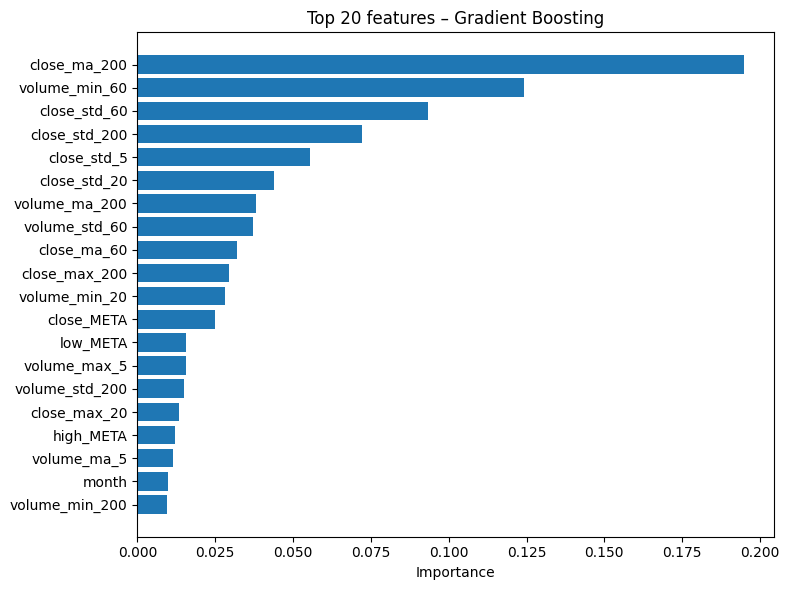

In [71]:
top_n = 20
top = feat_imp.head(top_n).iloc[::-1]

plt.figure(figsize=(8, 6))
plt.barh(top.index, top["importance"])
plt.title(f"Top {top_n} features – Gradient Boosting")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

The bar chart shows which features the Gradient Boosting model relies on most when making predictions.
Long-horizon moving averages and volatility/volume statistics are at the top, which suggests the model mainly uses information about medium-to-long-term trend and volatility regimes.

<a id="6a-simple-probability-based-entry-rule"></a>
## 6a. Simple probability-based entry rule

Finally, I define a simple rule:

> **Enter** when `P(good_trade) ≥ 0.5`.

I then compare the "hit rate" (share of `good_trade = 1`) among the selected days
to the unconditional base rate in the dataset.

This aim is to shows whether the model can meaningfully
tilt the odds towards better setups.

In [72]:
PROBA_THRESHOLD = 0.50

df_model["signal_long"] = (df_model["proba"] >= PROBA_THRESHOLD).astype(int)

base_rate = df_model["good_trade"].mean()
signal_mask = df_model["signal_long"] == 1

signal_rate = df_model.loc[signal_mask, "good_trade"].mean()
num_signals = signal_mask.sum()

print(f"Base rate of good trades               : {base_rate:.3f}")
print(f"Signal rate (proba >= {PROBA_THRESHOLD:.2f}) : {signal_rate:.3f}")
print(f"Number of signals                      : {num_signals}")

Base rate of good trades               : 0.314
Signal rate (proba >= 0.50) : 0.367
Number of signals                      : 392


<a id="6b-in-sample-roc-for-the-final-model-optimistic"></a>
## 6b. In-sample ROC for the final model (optimistic)

For reference, I also look at the in-sample ROC AUC of the final model
trained on all data. This is an upper bound: it reflects how well the
model fits the past, not how well it generalises. The more relevant
number is the out-of-sample AUC from the time-series CV above.

In [73]:
proba_train_full = final_clf.predict_proba(X)[:, 1]
train_full_auc = roc_auc_score(y, proba_train_full)

print(f"In-sample ROC AUC (full training data): {train_full_auc:.4f}")

In-sample ROC AUC (full training data): 0.9701


<a id="7-simple-equity-curve-vs-buy--hold"></a>
## 7. Simple equity curve vs. buy & hold

Here I convert the probability-based signal into a daily long/flat position:

- If `P(good_trade) ≥ 0.5` on day *t*, I go long on day *t+1*.
- Otherwise I stay flat.

Then I:

- Compute daily returns for META
- Apply the position to get strategy returns
- Compare the resulting equity curve to a buy & hold benchmark starting from 10,000 USD.


In this simplified backtest I assume that:

- I enter a long position at the next day’s close whenever the model’s probability exceeds the threshold (signal_long = 1).
- I stay invested as long as the signal remains 1, and exit on the next day after the signal drops back to 0.
- There is no explicit 20-day holding cap or separate TP/SL in this section – the exit is fully driven by the model turning the signal off.

In [74]:
START_CAPITAL = 10_000

df_bt = df_model.copy().sort_index()

price_col = "close_META"

# 1) Daily returns
df_bt["ret"] = df_bt[price_col].pct_change().fillna(0.0)

# 2) Position: use yesterday's signal for today's position
#    Entry rule:  if signal_long[t-1] == 1, we are long on day t.
#    Exit rule:   if signal_long[t-1] == 0, we are flat on day t.
df_bt["position"] = df_bt["signal_long"].shift(1).fillna(0.0)

# 3) Strategy returns = position * daily returns
df_bt["strategy_ret"] = df_bt["position"] * df_bt["ret"]

# 4) Equity curves
df_bt["equity_buy_hold"] = START_CAPITAL * (1 + df_bt["ret"]).cumprod()
df_bt["equity_strategy"] = START_CAPITAL * (1 + df_bt["strategy_ret"]).cumprod()

# 5) Final numbers
final_strat = df_bt["equity_strategy"].iloc[-1]
final_bh = df_bt["equity_buy_hold"].iloc[-1]

print(f"Final equity – strategy   : {final_strat:,.2f} USD")
print(f"Final equity – buy & hold : {final_bh:,.2f} USD")
print(f"Total return – strategy   : {final_strat / START_CAPITAL - 1:.2%}")
print(f"Total return – buy & hold : {final_bh / START_CAPITAL - 1:.2%}")

Final equity – strategy   : 14,421.53 USD
Final equity – buy & hold : 18,883.15 USD
Total return – strategy   : 44.22%
Total return – buy & hold : 88.83%


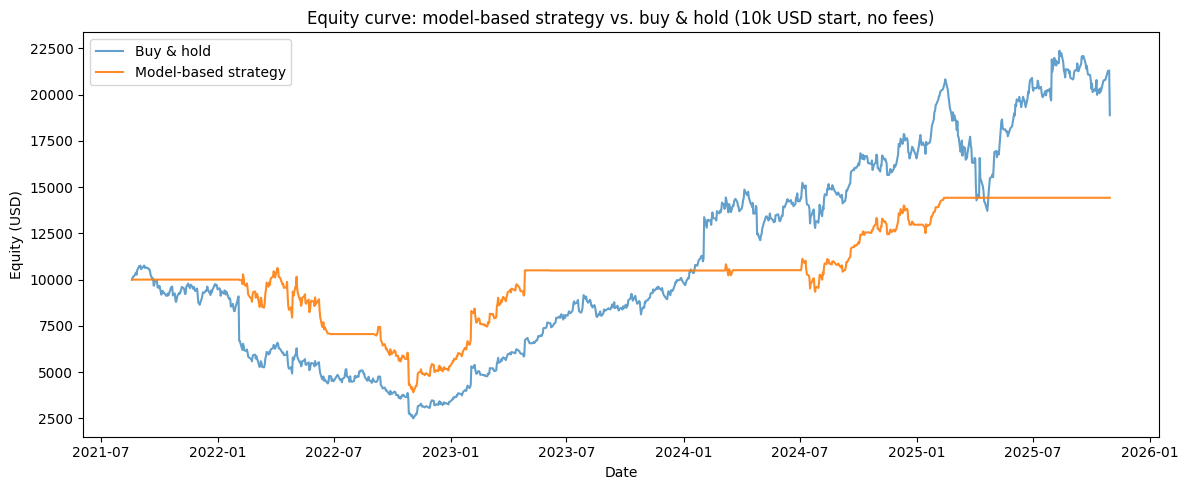

In [75]:
plt.figure(figsize=(12, 5))
plt.plot(df_bt.index, df_bt["equity_buy_hold"], label="Buy & hold", alpha=0.7)
plt.plot(df_bt.index, df_bt["equity_strategy"], label="Model-based strategy", alpha=0.9)
plt.title("Equity curve: model-based strategy vs. buy & hold (10k USD start, no fees)")
plt.xlabel("Date")
plt.ylabel("Equity (USD)")
plt.legend()
plt.tight_layout()
plt.show()

The blue line shows what happens if I buy META once and hold, while the orange line is the equity of the ML-based long/flat strategy with 10k USD start and full reinvestment.
The strategy protects capital better in large drawdowns (e.g. 2022), but it also stays out of many strong rallies, so in this simple version it ends up with ~14k vs. ~18.9k for buy-and-hold.

<a id="8-takeaways"></a>
## 8. Takeaways

This notebook is deliberately simple, but it covers the full loop:

- Start from raw daily OHLCV data (META)
- Engineer a rich but interpretable feature set (RSI, EMA, ATR, Bollinger Bands, MACD, rolling stats, lags)
- Define a forward-looking label that approximates “good long opportunities” given a TP/SL template
- Use time-aware cross-validation to avoid leakage
- Interpret the model via feature importance
- Translate probabilities into a simple rule and compare it to the base rate
- Compute strategy returns against buy & hold benchmark

In a production setting I would:
- Stress-test the label definition and thresholds
- Add more features that potentially improve accuracy (news sentiment, economic factors, etc.)
- Add proper transaction cost modeling and position sizing
- Run a full backtest including overlapping trades and risk management

Here the aim is to show the structure of my workflow rather than to propose a ready-to-trade strategy.